In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, uniform, bernoulli, t, beta

In [34]:
def normal_vs_t(mean=2, std=3, sample_size=50):
    
    norm_ppfs = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000)
    norm_pdf = norm.pdf(norm_ppfs)    
    
    ddof = sample_size - 1
    t_pffs = np.linspace(t.ppf(0.001, ddof), t.ppf(0.999, ddof), 1000)    
    t_pdf = t.pdf(t_pffs, ddof)
    
    plt.plot(norm_ppfs, norm_pdf, label='Normal Dist.', color='blue')
    plt.plot(t_pffs, t_pdf, label='t-Distribution', color='green')
    plt.title(f'Normal vs t-Distribution (df={ddof})')
    plt.xlabel('x')
    plt.ylabel('PDF')
    plt.show()

In [165]:
class ThompsonSampleGauss:
    """
    A class to perform Gaussian Thompson Sampling on the multi-armed bandit problem.
    """
    
    def __init__(self, bandits: int, means: np.ndarray, stds: np.ndarray, pulls: int) -> None:
        """
        Initializes the ThompsonSampleTest class.

        Args:
            bandits: the number of arms in the bandit problem.
            means: a numpy array representing the true means of the bandits.
            stds: a numpy array representing the true standard deviations of the bandits.
            pulls: the number of times to pull the arms of the bandit problem.
        """
        self.bandits = bandits
        self.prior_means = np.zeros(bandits)
        self.prior_stds = np.ones(bandits) * 1000
        self.actual_means = means
        self.actual_stds = stds
        self.pulls = pulls
        self.samples = np.zeros(bandits)
        self.mean_sequences = {n : [] for n in range(bandits)}
        self.stds_sequences = {n : [] for n in range(bandits)}
        
        for n in range(bandits):
            self.mean_sequences[n].append(0)
        for n in range(bandits):
            self.stds_sequences[n].append(1)
        
    def get_choice(self) -> int:
        """
        Samples the prior distributions to select the arm to pull. 
        Note that we sample it twice to get both a mean and a standard deviation.        
        
        Returns:
            The index of the arm to pull.
        """       
        sample_means = norm.rvs(self.prior_means, self.prior_stds)
        sample_stds = np.abs(norm.rvs(self.prior_means, self.prior_stds))
        
        return np.argmax(norm.rvs(sample_means, sample_stds))
    
    def get_reward(self, choice: int) -> float:        
        """
        Samples the distribution of the arm chosen to get a reward.

        Args:
            choice: The index of the arm chosen.
            
        Returns:
            The reward obtained from the chosen arm.
        """        
        reward = norm.rvs(self.actual_means[choice], self.actual_stds[choice])
        
        return reward
    
    def update_prior(self, choice: int, reward: float) -> None:
        """
        Updates the prior distribution for the chosen arm.

        Args:
            choice: The index of the arm chosen.
            reward: The reward obtained from the chosen arm.
        """       
        self.samples[choice] += 1
        self.prior_means[choice] = (self.prior_means[choice] * (self.samples[choice] - 1) + reward) / self.samples[choice]
        self.prior_stds[choice] = np.sqrt((self.prior_stds[choice]**2 * (self.samples[choice] - 1) + (reward - self.prior_means[choice])**2) / self.samples[choice])
        
        self.mean_sequences[choice].append(self.prior_means[choice])
        self.stds_sequences[choice].append(self.prior_stds[choice])
                                          
    def do_it(self) -> None:
        """
        Performs the Thompson Sampling algorithm for the specified number of pulls.
        """        
        for i in range(self.pulls):

            choice = self.get_choice()
            reward = self.get_reward(choice)
            
            self.update_prior(choice, reward)


In [166]:
g = ThompsonSampleGauss(5, [3, 4, 8, 9, 2], [5, 5, 3, 2, 9], 3223)
g.do_it()


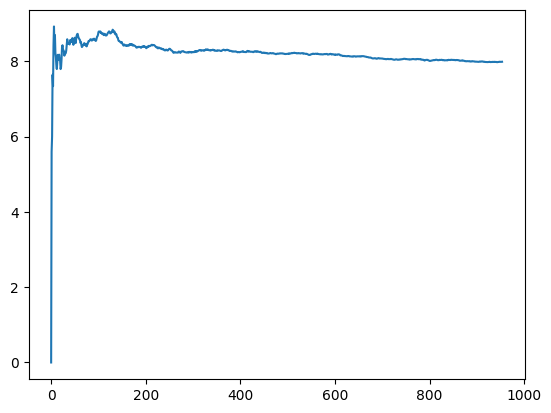

In [173]:
plt.plot(g.mean_sequences[2])